# Reevaluating Elusive Emotions in Woolf Through Quantitative Sentiment Analysis
KAELA OLSEN, Cornell University, English & Information Science<br>
<br> 
December 20, 2020<br>
ENGL 3520: Virginia Woolf<br> 
Professor Elizabeth Evans<br>

## 1. Introduction
Virginia Woolf (1882-1941), considered one of the most important 20th-century novelists, pioneered her own style of free indirect discourse and stream-of-conscious narratives. Many of her works, including the notable <em>Mrs. Dalloway</em> and <em>To the Lighthouse</em>, are iconic modernist texts that truly defined the genre and the era. Novels like these placed Woolf at the center of the modernist reinvention of literature to focus on the subjective, rather than objective, human experience. Furthermore, her critical essays, <em>A Room of One's Own</em> and <em>Three Guineas</em>,  positioned her as a respected and perceptive social critic who wrote in support of feminism and anti-colonial pacifism. 

Across all her texts, the intensity of Woolf's writing style allows her magnificent and unmatched ability to evoke emotion out of almost every and any situation, creating worlds abundant with sensation. Emotion and sentiment serve as omnipresent, omniscient characters in her works, characters so elusive and evasive it may seem impossible to accurately define and define. 

Through text-mining and data analysis, this project hopes to tackle this challenge of objectifying the subjective, to quantify the fluctuation of emotions within her characters, her worlds, and her ideas. By painting an alternate picture of the emotions that illuminate and illustrate the worlds Woolf creates, we can rediscover Woolf’s most influential novels, essays, and stories. 

<em>Research Questions:</em><br>
By quantifying the mood of Woolf’s sentences through sentiment analysis, we are provided new measures to compare and contrast emotion across texts. We hope to discover how our quantitative analysis of sentiment diverges from our qualitative analysis. What differences arise when replacing a human interpreter, reading sentence by sentence, with a computer interpreter that parses through sentence by sentence? How can these dissonances cause us to think more critically about Woolf's texts?

## 2. Data Collection with Web-Scraping
The data used for this sentiment analysis was web-scraped from online e-books provided by Project Gutenberg Australia, which provides free e-books by authors who died before 1955. This analysis looks at the following texts:

Novels:<br>
<em>The Voyage Out</em> (1915), <em>Night and Day</em> (1919), <em>Jacob's Room</em> (1922), <em>Mrs. Dalloway</em> (1925), <em>To the Lighthouse</em> (1927), <em>The Waves</em> (1931), <em>The Years</em> (1937), <em>Between the Acts</em> (1941).

Short Stories:<br>
"The Mark On the Wall" (1917), "Kew Gardens" (1919), "Street Haunting" (1930).

Biographies:<br>
<em>Orlando: A Biography</em> (1928), <em>Flush: A Biography</em> (1933).

Essays:<br>
"Modern Fiction" (1921), "Mr. Bennett and Mrs. Brown" (1923), <em>A Room of One's Own</em> (1929), <em>Three Guineas</em> (1938).

Most of these texts are formatted as e-books on their own Project Gutenberg web page. Below, a function, ‘text_from_url’,  is createtd to extract the relevant text from the webpage URLs, using requests to pull the URL's content, then BeautifulSoup to parse through the HTML to access the page's text and remove any extraneous text in from sections like headings, footers, or tables.

In [1]:
# First, importing some packages...
import re
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.transforms as transforms

In [2]:
# Function that pulls a textfield off a .html website
def text_from_url(url):
    '''Pull a textfield from a HTML website from each <p> div class.
    Returns a textfield.'''
    
    res = requests.get(url)
    html_page = res.content
    soup = BeautifulSoup(html_page, 'html.parser')
    text = soup.find_all(text=True)
    
    output = ''
    blacklist = ['[document]','a','b','big','blockquote','body','center','font','i','h1','h2','head','html','pre','style','table','td','title','tr']

    for t in text:
        if t.parent.name not in blacklist:
            output += '{} '.format(t)
            
    return output

As an example, we can see the textfield output that text_from_url would pull off of the Project Gutenberg webpage for <em>Mrs. Dalloway</em>. Here we print just the first five hundred characters:

In [3]:
mrs_dalloway_url = 'http://gutenberg.net.au/ebooks02/0200991h.html'
mrs_dalloway = text_from_url(mrs_dalloway_url)
mrs_dalloway[:500]

"\xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 Mrs. Dalloway said she would buy the flowers herself. For Lucy had her work cut out for her. The doors would be taken\r\noff their hinges; Rumpelmayer's men were coming. And then, thought\r\nClarissa Dalloway, what a morning--fresh as if issued to children on\r\na beach. What a lark! What a plunge! For so it had always seemed to her,\r\nwhen, with a little squeak of the hinges, which she could hear now,\r\nshe had burst open the French windows and plunged at Bourton into the\r\nopen air. How"

While we did pull out the entire novel’s text, we also caught a decent amount of gibberish! Now, we create a function that parses through this complicated jumble of characters to pull out a clean list of sentences.

In [4]:
# Function that parses through a textfield to extracts sentences
alphabets = "([A-Za-z])"
prefixes = "(Mr|St|Mrs|Ms|Dr|Prof|Capt|Cpt|Lt|Mt)[.]"
suffixes = "(Inc|Ltd|Jr|Sr|Co)"
starters = "(Mr|Mrs|Ms|Dr|He\s|She\s|It\s|They\s|Their\s|Our\s|We\s|But\s|However\s|That\s|This\s|Wherever)"
acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"

def extract_sentences(text):
    '''Manipulate a textfield into a list of strings, where each string is a new sentence.
    Returns a string of individual sentences within a textfield.'''
   
    text = " " + text + "  "
    text = text.replace("\n"," ")
    text = text.replace("\r","")
    text = re.sub(prefixes,"\\1<prd>",text)
    
    if "Ph.D" in text: text = text.replace("Ph.D.","Ph<prd>D<prd>")
    if "..." in text: text = text.replace("...","<prd><prd><prd>")

    text = re.sub("\s" + alphabets + "[.] "," \\1<prd> ",text)
    text = re.sub(acronyms+" "+starters,"\\1<stop> \\2",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>\\3<prd>",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>",text)
    text = re.sub(" "+suffixes+"[.] "+starters," \\1<stop> \\2",text)
    text = re.sub(" "+suffixes+"[.]"," \\1<prd>",text)
    text = re.sub(" " + alphabets + "[.]"," \\1<prd>",text)
    
    if "”" in text: text = text.replace(".”","”.")
    if "\"" in text: text = text.replace(".\"","\".")
    if "!" in text: text = text.replace("!\"","\"!")
    if "?" in text: text = text.replace("?\"","\"?")

    text = text.replace("\ ", "")
    text = text.replace(".",".<stop>")
    text = text.replace("?","?<stop>")
    text = text.replace("!","!<stop>")
    text = text.replace("<prd>",".")

    sentences = text.split("<stop>")
    sentences = sentences[:-1]
    sentences = [s.strip() for s in sentences]

    return sentences

This function, ‘extract_sentences’ takes the clump of text, sorts through character by character, replaces, and removes any unwanted letters or symbols. There are a few hoops to jump over: successfully discerning sentence breaks from words like "Dr.," "Inc.," quotations that indicate new speakers, and dashes or colons. We can see how successful our function is by trying it with the <em>Mrs. Dalloway</em> textfield.

In [5]:
# Inputting the output of extract_sentences into a list
mrs_dalloway_sentence_list = extract_sentences(mrs_dalloway)
# Printing the first ten sentences of Mrs. Dalloway
mrs_dalloway_sentence_list[:10]

['Mrs. Dalloway said she would buy the flowers herself.',
 'For Lucy had her work cut out for her.',
 "The doors would be taken off their hinges; Rumpelmayer's men were coming.",
 'And then, thought Clarissa Dalloway, what a morning--fresh as if issued to children on a beach.',
 'What a lark!',
 'What a plunge!',
 'For so it had always seemed to her, when, with a little squeak of the hinges, which she could hear now, she had burst open the French windows and plunged at Bourton into the open air.',
 'How fresh, how calm, stiller than this of course, the air was in the early morning; like the flap of a wave; the kiss of a wave; chill and sharp and yet (for a girl of eighteen as she then was) solemn, feeling as she did, standing there at the open window, that something awful was about to happen; looking at the flowers, at the trees with the smoke winding off them and the rooks rising, falling; standing and looking until Peter Walsh said, "Musing among the vegetables"?',
 '--was that it?',

Success! The function provided a nice list with each sentence in <em>Mrs. Dalloway</em>. However, there is not much opportunity for data analysis with just this textfield; thus, we can turn this into a handy dataframe via a package called pandas.

In [6]:
# Turning the list of sentences into a pandas dataframe
mrs_dalloway_sentence_df = pd.DataFrame(mrs_dalloway_sentence_list).rename(columns={0: 'sentence'})
mrs_dalloway_sentence_df

,sentence
0,Mrs. Dalloway said she would buy the flowers h...
1,For Lucy had her work cut out for her.
2,The doors would be taken off their hinges; Rum...
3,"And then, thought Clarissa Dalloway, what a mo..."
4,What a lark!
...,...
3709,what is this ecstasy?
3710,he thought to himself.
3711,What is it that fills me with extraordinary ex...
3712,"It is Clarissa, he said."


Previewing the dataframe shows us the first five and last five sentences of the book, which all match up. As shown by the 3714 rows, we also see that there are 3714 sentences in <em>Mrs. Dalloway</em>. The last sentence, "For there she was," reads even more powerfully when alone in its own dataframe cell!

## 3. Processing Textfields Into Sentences
Now we have a sturdy process in place for extracting each publication's text off of the Project Gutenberg website, processing the extraction, and polishing it off into sentences. However, this process from start to finish was quite tedious, so if we want to repeat it for a dozen or so Woolfean texts, we should streamline it into one function for the rest of our data processing.

In [7]:
# Function that turns a .html webpage into dataframe of sentences
def url_to_df(url):
    '''Extract each sentence of a given text from the HTML url provided.
    Returns dataframe where each row is an individual sentence.'''
    
    text = text_from_url(url)
    sentences = extract_sentences(text)
    df = pd.DataFrame(sentences).rename(columns={0: 'sentence'})
    
    return df

There is a caveat; only about half of Woolf's texts are on HTML pages. The rest are on TXT pages (as indicated by the '.txt' at the end of the URL), which gives us the entire chunk of text directly. We can adjust our function 'url_to_df' into a new one, 'txt_to_df', that stores the text, runs the same extract_sentences function, and pulls it all together into a dataframe.

In [8]:
# Function that turns a .txt webpage into dataframe of sentences
def txt_to_df(txt):
    '''Extract each sentence of a given text from the TXT url provided.
    Returns dataframe where each row is an individual sentence.'''
    
    response = requests.get(txt)
    data = response.text
    sentences = extract_sentences(data)
    df = pd.DataFrame(sentences).rename(columns={0: 'sentence'})
    
    return df

The functions we created above, url_to_df and txt_to_df, successfully create sentence dataframes for us.
Unfortunately, a few websites had tricky formatting for the texts' headings and subheadings, produced some rows like 'VIRGINIA WOOLF PUBLISHED BY LEONARD AND VIRGINIA WOOLF AT THE HOGARTH PRESS TAVISTOCK SQUARE LONDON W.C.I 1924 MR.'. However, by removing these wonky rows through a little manipulation, we escaped with some clean datasets!

In [9]:
# The Voyage Out (1915)
voyage_out_url = 'http://gutenberg.net.au/ebooks/m00020.txt'
voyage_out = txt_to_df(voyage_out_url)
voyage_out['sentence'][0] = voyage_out['sentence'][0].replace('Project Gutenberg Australia    THE VOYAGE OUT (1915) by Virginia Woolf (1882-1941)    Chapter I   ', '', 1)
voyage_out

,sentence
0,As the streets that lead from the Strand to th...
1,"If you persist, lawyers' clerks will have to m..."
2,In the streets of London where beauty goes unr...
3,One afternoon in the beginning of October when...
4,Angry glances struck upon their backs.
...,...
8399,Pepper beaten at last?
8400,"I congratulate you""!"
8401,"said Arthur Venning, who was wheeling old Mrs...."
8402,All these voices sounded gratefully in St. Joh...


In [10]:
# Mr. Bennett and Mrs. Brown (1923)
bennett_brown_url = 'http://www.gutenberg.org/files/63022/63022-h/63022-h.htm'
bennett_brown = url_to_df(bennett_brown_url).iloc[2:].reset_index(drop=True)
bennett_brown['sentence'][0] = bennett_brown['sentence'][0].replace('BROWN ', '', 1)
bennett_brown

,sentence
0,"It seems to me possible, perhaps desirable, th..."
1,"And when I asked myself, as your invitation to..."
2,"Catch me if you can""."
3,Most novelists have the same experience.
4,"Some Brown, Smith, or Jones comes before them ..."
...,...
376,"Tolerate the spasmodic, the obscure, the fragm..."
377,Your help is invoked in a good cause.
378,For I will make one final and surpassingly ras...
379,But it can only be reached if we are determine...


In [11]:
# Flush: A Biography (1933)
flush_url = 'http://gutenberg.net.au/ebooks03/0301041h.html'
flush = url_to_df(flush_url)
flush

,sentence
0,It is universally admitted that the family fro...
1,Therefore it is not strange that the origin of...
2,Many million years ago the country which is no...
3,Ages passed; vegetation appeared; where there ...
4,There is nothing in this that calls for questi...
...,...
2148,"[10] ""he was now dead""."
2149,It is certain that Flush died; but the date an...
2150,The only reference consists in the statement t...
2151,Mrs. Browning was buried in the English Cemete...


In [12]:
# Mrs. Dalloway (1925)
mrs_dalloway_url = 'http://gutenberg.net.au/ebooks02/0200991h.html'
mrs_dalloway = url_to_df(mrs_dalloway_url)
mrs_dalloway 

,sentence
0,Mrs. Dalloway said she would buy the flowers h...
1,For Lucy had her work cut out for her.
2,The doors would be taken off their hinges; Rum...
3,"And then, thought Clarissa Dalloway, what a mo..."
4,What a lark!
...,...
3709,what is this ecstasy?
3710,he thought to himself.
3711,What is it that fills me with extraordinary ex...
3712,"It is Clarissa, he said."


In [13]:
# To the Lighthouse (1927)
to_the_lighthouse_url = 'http://gutenberg.net.au/ebooks01/0100101h.html'
to_the_lighthouse = url_to_df(to_the_lighthouse_url)
to_the_lighthouse['sentence'][0] = to_the_lighthouse['sentence'][0].replace('by', '', 1)
to_the_lighthouse

,sentence
0,"""Yes, of course, if it's fine tomorrow,"" said..."
1,"""But you'll have to be up with the lark,"" she ..."
2,To her son these words conveyed an extraordina...
3,"Since he belonged, even at the age of six, to ..."
4,It was fringed with joy.
...,...
3510,"she asked herself, taking up her brush again."
3511,She looked at the steps; they were empty; she ...
3512,"With a sudden intensity, as if she saw it clea..."
3513,It was done; it was finished.


In [14]:
# Orlando: A Biography (1928)
orlando_url = 'http://gutenberg.net.au/ebooks02/0200331h.html'
orlando = url_to_df(orlando_url).iloc[18:].reset_index(drop=True)
orlando

,sentence
0,"He--for there could be no doubt of his sex, th..."
1,"It was the colour of an old football, and more..."
2,"Orlando's father, or perhaps his grandfather, ..."
3,Orlando's fathers had ridden in fields of asph...
4,"So too would Orlando, he vowed."
...,...
3407,Her pearls burnt like a phosphorescent flare i...
3408,"And as Shelmerdine, now grown a fine sea capta..."
3409,'It is the goose!
3410,' Orlando cried.


In [15]:
# Three Guineas (1938)
three_guineas_url = 'http://gutenberg.net.au/ebooks02/0200931h.html'
three_guineas = url_to_df(three_guineas_url)
three_guineas

,sentence
0,Three years is a long time to leave a letter u...
1,"I had hoped that it would answer itself, or th..."
2,But there it is with its question--How in your...
3,--still unanswered.
4,It is true that many answers have suggested th...
...,...
3483,.
3484,Cette individualité n'a par elle seule ni sign...
3485,Elle ne prend un sens quelconque qu'en devenan...
3486,"' ( by George Sand, pp."


In [16]:
# Between the Acts (1941)
between_the_acts_url = 'http://gutenberg.net.au/ebooks03/0301171h.html'
between_the_acts = url_to_df(between_the_acts_url)
between_the_acts

,sentence
0,"It was a summer's night and they were talking,..."
1,The county council had promised to bring water...
2,"Mrs. Haines, the wife of the gentleman farmer,..."
3,Then there was silence; and a cow coughed; and...
4,"But, then, as a small child in a perambulator,..."
...,...
4455,The house had lost its shelter.
4456,"It was night before roads were made, or houses."
4457,It was the night that dwellers in caves had wa...
4458,Then the curtain rose.


In [17]:
# The Mark on the Wall (1917)
mark_on_the_wall_url = 'http://www.gutenberg.org/files/29220/29220-h/29220-h.htm#THE_MARK_ON_THE_WALL'
mark_on_the_wall = url_to_df(mark_on_the_wall_url).iloc[2:].reset_index(drop=True)
mark_on_the_wall

,sentence
0,"From room to room they went, hand in hand, lif..."
1,"""Here we left it,"" she said."
2,"And he added, ""Oh, but here too""!"
3,"""It's upstairs,"" she murmured."
4,"""And in the garden,"" he whispered."
...,...
1167,Nothing ever happens.
1168,Curse this war; God damn this war!
1169,"... All the same, I don't see why we should ha..."
1170,"Ah, the mark on the wall!"


In [18]:
# Night and Day (1919)
night_day_url = 'http://gutenberg.net.au/ebooks/m00019.txt'
night_day = txt_to_df(night_day_url)
night_day['sentence'][0] = night_day['sentence'][0].replace('Project Gutenberg Australia    Night and Day by Virginia Woolf   TO VANESSA BELL BUT, LOOKING FOR A PHRASE, I FOUND NONE TO STAND BESIDE YOUR NAME      NIGHT AND DAY    CHAPTER I  ', '', 1)
night_day

,sentence
0,"It was a Sunday evening in October, and in com..."
1,Perhaps a fifth part of her mind was thus occu...
2,"But although she was silent, she was evidently..."
3,A single glance was enough to show that Mrs. H...
4,Considering that the little party had been sea...
...,...
9294,Katharine pushed the door half open and stood ...
9295,The light lay in soft golden grains upon the d...
9296,"For a moment they waited, and then loosed thei..."
9297,"""Good night,"" he breathed."


In [19]:
# A Room of One's Own (1929)
room_of_ones_own_url = 'http://gutenberg.net.au/ebooks02/0200791.txt'
room_of_ones_own = txt_to_df(room_of_ones_own_url).iloc[15:].reset_index(drop=True)
room_of_ones_own['sentence'][0] = room_of_ones_own['sentence'][0].replace(']    ONE    ', '', 1)
room_of_ones_own

,sentence
0,au ------------------------------------------...
1,"The papers were too long to be read in full, a..."
2,"] ONE But, you may say, we asked you to ..."
3,I will try to explain.
4,When you asked me to speak about women and fic...
...,...
1585,"This opportunity, as I think, it is now coming..."
1586,For my belief is that if we live another centu...
1587,Drawing her life from the lives of the unknown...
1588,"As for her coming without that preparation, wi..."


In [20]:
# Jacob's Room (1922)
jacobs_room_url = 'http://gutenberg.net.au/ebooks/m00018.txt'
jacobs_room = txt_to_df(jacobs_room_url)
jacobs_room['sentence'][0] = jacobs_room['sentence'][0].strip('Project Gutenberg Australia    Jacob\'s Room by Virginia Woolf     CHAPTER ONE   ')
jacobs_room

,sentence
0,"""So of course,"" wrote Betty Flanders, pressing..."
1,"Slowly welling from the point of her gold nib,..."
2,The entire bay quivered; the lighthouse wobble...
3,She winked quickly.
4,Accidents were awful things.
...,...
3431,"""Such confusion everywhere""!"
3432,"exclaimed Betty Flanders, bursting open the be..."
3433,Bonamy turned away from the window.
3434,"""What am I to do with these, Mr. Bonamy""?"


A handful of texts, particularly the short stories and essays, prove more challenging to extract. For example, "Street Haunting" is problematic because of its position halfway down the page. These texts are dealt with here on a case by case basis, using the .split() function to manually find the locations to start extraction.

In [21]:
# Street Haunting (1930)
street_haunting_url = 'http://gutenberg.net.au/ebooks02/0200771.txt'
book = requests.get(street_haunting_url).text
x = book.split('STREET HAUNTING: A LONDON ADVENTURE (Written in 1930.)')[1].split('JONES AND WILKINSON(Drawn from the MEMOIRS OF TATE WILKINSON,4 vols.,1790.)')[0]
street_haunting = pd.DataFrame(extract_sentences(x)).rename(columns={0: 'sentence'})
street_haunting

,sentence
0,No one perhaps has ever felt passionately towa...
1,But there are circumstances in which it can be...
2,As the foxhunter hunts in order to preserve th...
3,The hour should be the evening and the season ...
4,We are not then taunted as in the summer by th...
...,...
195,And what greater delight and wonder can there ...
196,That is true: to escape is the greatest of ple...
197,"Still as we approach our own doorstep again, i..."
198,Here again is the usual door; here the chair t...


In [22]:
# Kew Gardens (1919)
kew_gardens_url = 'http://www.gutenberg.org/files/29220/29220-h/29220-h.htm#KEW_GARDENS'
book = text_from_url(kew_gardens_url)
x = book.split('A wave\r\nrolls beneath the blue bells. But the cathedral\'s different, cold,\r\nincense laden, faint blue with the veils of madonnas.')[1]
kew_gardens = pd.DataFrame(extract_sentences(x)).rename(columns={0: 'sentence'})[:91].reset_index(drop = True)
kew_gardens

,sentence
0,From the oval-shaped flower-bed there rose per...
1,The petals were voluminous enough to be stirre...
2,"The light fell either upon the smooth, grey ba..."
3,"Instead, the drop was left in a second silver ..."
4,Then the breeze stirred rather more briskly ov...
...,...
86,It seemed as if all gross and heavy bodies had...
87,Voices.
88,"Yes, voices."
89,"Wordless voices, breaking the silence suddenly..."


In [23]:
# Modern Fiction (1921)
modern_fiction_url = 'http://gutenberg.net.au/ebooks03/0300031h.html#C12'
book = text_from_url(modern_fiction_url)
x = book.split('confidence in her own success')[1].split('confidence in her own success')[0]
modern_fiction = pd.DataFrame(extract_sentences(x)).rename(columns={0: 'sentence'})[1:105].reset_index(drop=True)
modern_fiction

,sentence
0,"In making any survey, even the freest and loos..."
1,With their simple tools and primitive material...
2,Their masterpieces certainly have a strange ai...
3,And yet the analogy between literature and the...
4,It is doubtful whether in the course of the ce...
...,...
99,The voice of protest is the voice of another a...
100,English fiction from Sterne to Meredith bears ...
101,But any deductions that we may draw from the c...
102,"""The proper stuff of fiction"" does not exist; ..."


In [24]:
# The Years (1937)
the_years_url = 'http://gutenberg.net.au/ebooks03/0301221h.html'
the_years = url_to_df(the_years_url).reset_index(drop=True)
the_years

,sentence
0,It was an uncertain spring.
1,"The weather, perpetually changing, sent clouds..."
2,"In the country farmers, looking at the fields,..."
3,But in April such weather was to be expected.
4,"Thousands of shop assistants made that remark,..."
...,...
13518,"""And now""?"
13519,"she said, looking at Morris, who was drinking ..."
13520,"""And now""?"
13521,"she asked, holding out her hands to him."


We cannot use the same function as the one above for <em>The Waves</em>, as it has a sizeable introductory portion in italics, which the function above is programmed to cut out. Below, I extract the textfield from the site manually and then put each sentence into the dataframe.

In [25]:
# The Waves (1931)
the_waves_url = 'http://gutenberg.net.au/ebooks02/0201091h.html'
res = requests.get(the_waves_url)
html_page = res.content
soup = BeautifulSoup(html_page, 'html.parser')
text = soup.find_all(text=True)

output = ''
blacklist = ['[document]','a','b','big','blockquote','body','center','font','h1','h2','head','html','pre','style','table','td','title','tr']

for t in text:
    if t.parent.name not in blacklist:
        output += '{} '.format(t)
x = output

the_waves = pd.DataFrame(extract_sentences(x)).rename(columns={0: 'sentence'})
the_waves['sentence'][0] = the_waves['sentence'][0].strip('a treasure-trove of literature \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 ')
the_waves

,sentence
0,The sun had not yet risen.
1,"The sea was indistinguishable from the sky, ex..."
2,Gradually as the sky whitened a dark line lay ...
3,"As they neared the shore each bar rose, heaped..."
4,"The wave paused, and then drew out again, sigh..."
...,...
5191,Death is the enemy.
5192,It is death against whom I ride with my spear ...
5193,I strike spurs into my horse.
5194,"Against you I will fling myself, unvanquished ..."


## 4. Semantic Analysis with the Vader Method
Now that we have dataframes of sentences the next challenge is correctly quantifying the text's very qualitative characteristics. With sentiment analysis, we can perceive a very subjective concept through objective terms like numbers. Unlike humans, computers struggle with understanding the double meanings, innuendos, negations, or the evoked (but not articulated) emotions in text. Thus, while it may seem easy at first, sentiment analysis is a tricky task.

A method for sentiment analysis is Vader (Valence Aware Dictionary and Sentiment Reasoner). Vader is a lexicon and rule-based sentiment analysis tool, sensitive to both the polarity (positive or negative) and intensity (strength) of emotion. Available in the NLTK package, the Vader sentiment analysis relies on a dictionary of approximately 7,500 words, emoticons, emojis, acronyms, and commonly used slang that maps lexical features to emotion intensities, known as sentiment scores. These scores represent the proportion of a text that expresses positive, negative, or neutral opinion, and vader_compound shows the weighted composite of these scores. The Vader method scores an entire sentence, not just the individual words; this is great, as it allows the algorithm to adjust for negations, such as "not," booster words, such as "remarkably." 

In [26]:
# Importing the Vader package
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

Below, we create a function, ‘vaderize’ that computes Vader polarity scores for a certain textfield. We can apply 'vaderize' to each dataframe of Woolf's texts, and create new dataframes that contain the compound, positive, negative, and neutral vader scores for every single sentence in each of Woolf's works.

In [27]:
# Function that performs the 'analyzer' function on each sentence in the dataframe
def vaderize(df, textfield):
    '''Compute the Vader polarity scores for a textfield.
    Returns scores and original dataframe.'''
    
    analyzer = SentimentIntensityAnalyzer()
    sentiment = df[textfield].apply(analyzer.polarity_scores)
    sdf = pd.DataFrame(sentiment.tolist()).add_prefix('vader_')
    df_combined = pd.concat([df, sdf], axis=1)
    
    return df_combined

In [28]:
# Apply 'vaderize' to each text's sentence dataframe
voyage_out_vader = vaderize(voyage_out, 'sentence')
night_day_vader = vaderize(night_day, 'sentence')
room_of_ones_own_vader = vaderize(room_of_ones_own, 'sentence')
mark_on_the_wall_vader = vaderize(mark_on_the_wall, 'sentence')
modern_fiction_vader = vaderize(modern_fiction, 'sentence')
bennett_brown_vader = vaderize(bennett_brown, 'sentence')
flush_vader = vaderize(flush, 'sentence')
jacobs_room_vader = vaderize(jacobs_room, 'sentence')
mrs_dalloway_vader = vaderize(mrs_dalloway, 'sentence')
to_the_lighthouse_vader = vaderize(to_the_lighthouse, 'sentence')
orlando_vader = vaderize(orlando, 'sentence')
three_guineas_vader = vaderize(three_guineas, 'sentence')
between_the_acts_vader = vaderize(between_the_acts, 'sentence')
kew_gardens_vader = vaderize(kew_gardens, 'sentence')
street_haunting_vader = vaderize(street_haunting, 'sentence')
the_waves_vader = vaderize(the_waves , 'sentence')
the_years_vader = vaderize(the_years , 'sentence')

In [29]:
# Create a new dataframe of the average neg, pos, neu, compound vader scores for each text
# Ordered chronologically
vader_means = pd.DataFrame({'voyage': voyage_out_vader.mean(),
                            'mark': mark_on_the_wall_vader.mean(),
                            'kew': kew_gardens_vader.mean(),
                            'night': night_day_vader.mean(),
                            'modern': modern_fiction_vader.mean(),
                            'jacobs': jacobs_room_vader.mean(),
                            'bennett': bennett_brown_vader.mean(),
                            'dalloway': mrs_dalloway_vader.mean(),
                            'lighthouse': to_the_lighthouse_vader.mean(),
                            'orlando': orlando_vader.mean(),
                            'room': room_of_ones_own_vader.mean(),
                            'street': street_haunting_vader.mean(),
                            'waves': the_waves_vader.mean(),
                            'flush': flush_vader.mean(),
                            'years': the_years_vader.mean(),
                            'guineas': three_guineas_vader.mean(),
                            'bta': between_the_acts_vader.mean(),})

In [30]:
vader_means

,voyage,mark,kew,night,modern,jacobs,bennett,dalloway,lighthouse,orlando,room,street,waves,flush,years,guineas,bta
vader_neg,0.065475,0.068770,0.038648,0.063618,0.066212,0.058867,0.070496,0.071007,0.062625,0.062671,0.073160,0.046180,0.068098,0.076285,0.046501,0.057482,0.048145
vader_neu,0.845063,0.840021,0.892264,0.844516,0.813904,0.870237,0.851186,0.836802,0.855867,0.854099,0.839597,0.872415,0.866101,0.864608,0.892447,0.865782,0.897928
vader_pos,0.089460,0.091216,0.069077,0.091864,0.119856,0.070893,0.078320,0.092197,0.081510,0.083227,0.087248,0.081385,0.065802,0.059105,0.061052,0.076732,0.053924
vader_compound,0.068618,0.053511,0.050577,0.083261,0.165230,0.043090,0.071440,0.071966,0.062297,0.071439,0.074501,0.155588,0.016782,-0.007701,0.034232,0.071169,0.028915


### Sentence Vader Scores at a Glance

In [31]:
# Average compound vader score for each of Woolf's works
# Ranked in descending order
vader_means.loc['vader_compound'].sort_values(ascending = False)

modern        0.165230
street        0.155588
night         0.083261
room          0.074501
dalloway      0.071966
bennett       0.071440
orlando       0.071439
guineas       0.071169
voyage        0.068618
lighthouse    0.062297
mark          0.053511
kew           0.050577
jacobs        0.043090
years         0.034232
bta           0.028915
waves         0.016782
flush        -0.007701
Name: vader_compound, dtype: float64

Now, with these dataframes, we can start comparing the sentiment across texts. A positive vader_compound score means the sentence is generally positive, and a negative means the sentence is generally negative. As we can see, according to the Vader method, <em>Flush: A Biography</em> is the most negative text overall. It appears that "Modern Fiction", on the other hand, had the most positive sentiment.

In [32]:
# Average positive vader score for each of Woolf's works
# Ranked in descending order
vader_means.loc['vader_pos'].sort_values(ascending = False)

modern        0.119856
dalloway      0.092197
night         0.091864
mark          0.091216
voyage        0.089460
room          0.087248
orlando       0.083227
lighthouse    0.081510
street        0.081385
bennett       0.078320
guineas       0.076732
jacobs        0.070893
kew           0.069077
waves         0.065802
years         0.061052
flush         0.059105
bta           0.053924
Name: vader_pos, dtype: float64

Ranking the texts based on descending vader_pos scores shows that "Modern Fiction", <em>Mrs. Dalloway</em>, and <em>Night and Day</em> have the most extreme positive emotion. Examining purely vader_neg can show us that the most negative texts are <em>Flush</em>, <em>A Room of One's Own</em>, and <em>Mrs. Dalloway</em>.

In [33]:
# Average negative vader score for each of Woolf's works
# Ranked in descending order
vader_means.loc['vader_neg'].sort_values(ascending = False)

flush         0.076285
room          0.073160
dalloway      0.071007
bennett       0.070496
mark          0.068770
waves         0.068098
modern        0.066212
voyage        0.065475
night         0.063618
orlando       0.062671
lighthouse    0.062625
jacobs        0.058867
guineas       0.057482
bta           0.048145
years         0.046501
street        0.046180
kew           0.038648
Name: vader_neg, dtype: float64

While summary statistics are interesting, it would be much better if we could visualize this data...

## 5. Visualizing Sentiment Shifts Across Woolf's Career

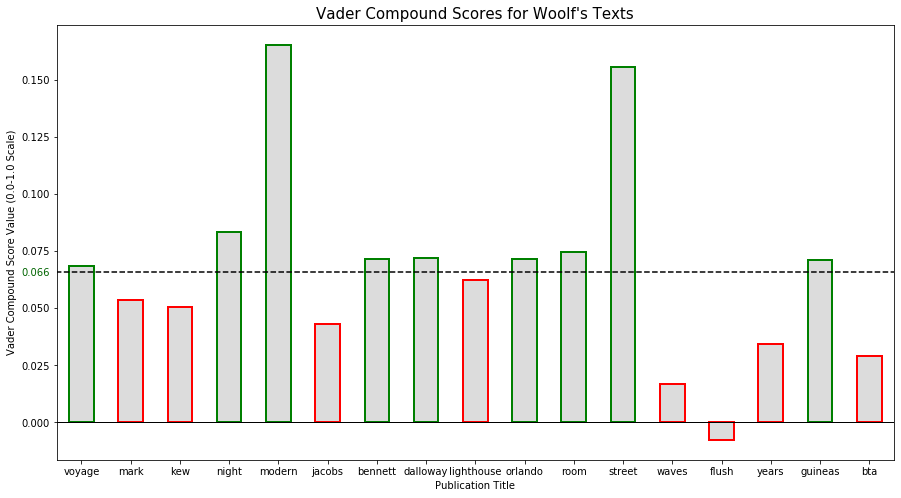

In [34]:
# Bar chart with average compound vader score for each text
# Ordered chronologically

df = vader_means.loc['vader_compound']

ax = df.plot.bar(rot = 0, 
                 figsize = (15, 8), 
                 color = 'gainsboro',
                 ec = ['green', 'red','red', 'green','green','red','green','green', 'red','green','green','green','red','red','red', 'green', 'red'],
                 linewidth = 2)

ax.hlines(df.mean(), -1, 17, linestyles='dashed')
plt.axhline(linewidth=1, color='black')
trans = transforms.blended_transform_factory(ax.get_yticklabels()[0].get_transform(), ax.transData)
ax.text(0, df.mean(), "{:.3f}".format(df.mean()), color="darkgreen", transform=trans ,ha="right", va="center")

plt.title("Vader Compound Scores for Woolf's Texts", fontsize = 15)
plt.xlabel("Publication Title")
plt.ylabel("Vader Compound Score Value (0.0-1.0 Scale)")
plt.show()

The bar chart above visualizes the average compound vader score for each of Woolf's texts. On a scale of 0 to 1, across the texts analyzed in this project, the average sentimentality was 0.066 positive. The texts 'sadder' than average, bordered in red, are "The Mark on the Wall" (1917), "Kew Gardens"(1919), <em>Jacob's Room</em> (1922), <em>To the Lighthouse</em> (1927), <em>The Waves</em> (1931), <em>Flush: A Biography</em> (1933), <em>The Years</em> (1937), and <em>Between the Acts</em> (1941). The texts 'happier' than average are <em>The Voyage Out</em> (1915), <em>Night and Day</em> (1919), "Modern Fiction" (1921), "Mr. Bennett and Mrs. Brown" (1923), <em>Mrs. Dalloway</em>, <em>Orlando: A Biography</em> (1928), <em>A Room of One's Own</em> (1929), "Street Haunting: A London Adventure", and <em>Three Guineas</em> (1938).

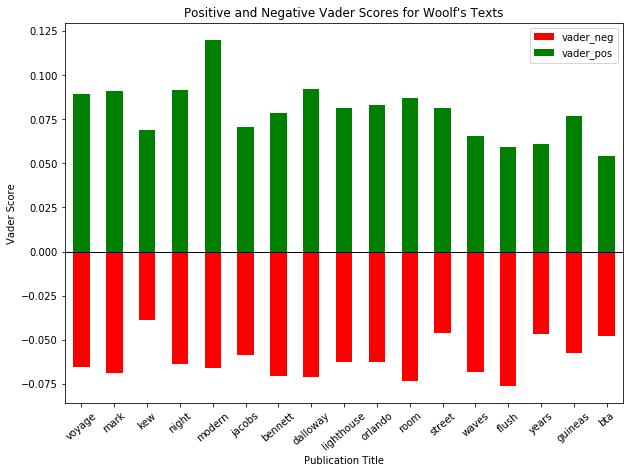

In [35]:
# Bar chart with average positive and average negative vader score for each text
# Ordered chronologically

plotdata = vader_means.drop(['vader_neu', 'vader_compound'])
plotdata = plotdata.T
plotdata['vader_neg'] = plotdata['vader_neg']*(-1)

plotdata.plot(kind='bar', stacked=True, color = ['red', 'green'], rot = 40, figsize = (10,7))
plt.axhline(linewidth=1, color='black')

plt.title("Positive and Negative Vader Scores for Woolf's Texts")
plt.xlabel("Publication Title")
plt.ylabel("Vader Score")
plt.show()

Here, we break apart the vader_compound score, as it allows us to see the magnitude to which each of the positive and negative sentiments are expressed throughout the texts.

### Chronological Emotion Across Woolf's Works
Woolf's career was not without its inidivudal ups and downs, particularly given the tumultuous context of social distress, impending world wars, family deaths, and her own mental illnesses. 

It might be interesting to see how the calculated vader scores increase or decrease as we move further into Woolf's career. We can find the average compound, positive, and negative vader scores for each of Woolf's texts. Then, we can see how these scores change across time and works by ordering the texts in chronological order!

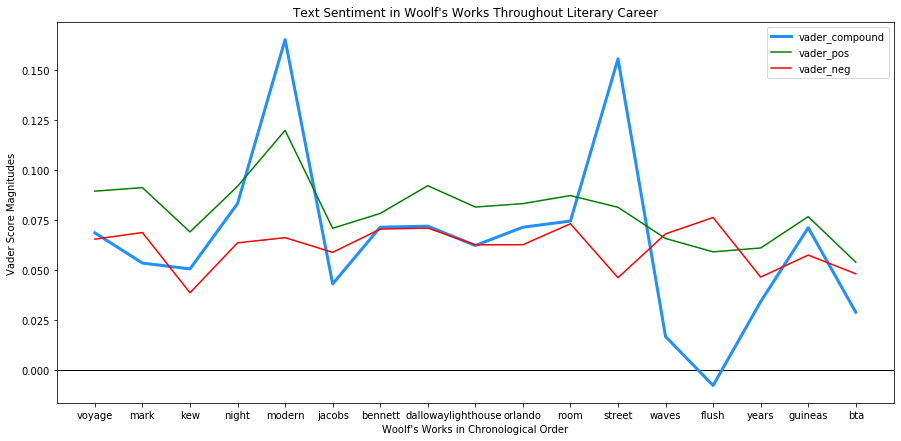

In [36]:
# Line plot with average compound vader score for each text
# Ordered chronologically

plt.figure(figsize=(15,7))
plt.axhline(linewidth=1, color='black')
plt.plot(vader_means.loc['vader_compound'], label = 'vader_compound', color = 'dodgerblue',linewidth = 3)
plt.plot(vader_means.loc['vader_pos'], label = 'vader_pos', color = 'green', linewidth = 1.5)
plt.plot(vader_means.loc['vader_neg'], label = 'vader_neg', color = 'red', linewidth = 1.5)

plt.xlabel("Woolf's Works in Chronological Order")
plt.ylabel('Vader Score Magnitudes')
plt.title("Text Sentiment in Woolf's Works Throughout Literary Career")
plt.legend()
plt.show()

Here, we can observe the computed fluctuations in each text's magnitude of positive and negative emotion in chronological order. It seems that "Modern Fiction" had the highest intensity of positive emotion, while <em>Flush: A Biography</em> had the highest value for negative emotion. From looking at how the intensities as time passes, we can see both emotions remain relatively constant, aside from a slight decline in positive vader scores for the texts towards the latter half of Woolf's career. It might be more useful to observe sentiment trends within genres, as the general sentiment of a biography might be much different than that of a polemic. 

### Chronological Emotion Across Novels
Woolf's lyrical technique is incredibly distinctive for its seamless evocation of emotion within and between characters. Quantifying sentiment specifically in her novels and comparing across each one might provide new insight into her most significant works of her most renowned genre.

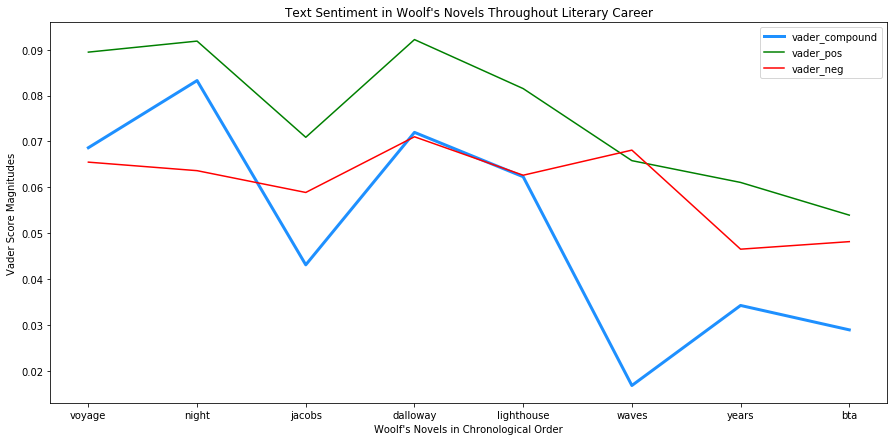

In [37]:
# Line plot with average compound vader score for each novel
# Ordered chronologically

novel_df = vader_means[['voyage', 'night', 'jacobs', 'dalloway', 'lighthouse', 'waves', 'years', 'bta']]

plt.figure(figsize=(15, 7))
plt.plot(novel_df.loc['vader_compound'], label = 'vader_compound', color = 'dodgerblue',linewidth = 3)
plt.plot(novel_df.loc['vader_pos'], label = 'vader_pos', color = 'green',linewidth = 1.5)
plt.plot(novel_df.loc['vader_neg'], label = 'vader_neg', color = 'red',linewidth = 1.5)

plt.xlabel("Woolf's Novels in Chronological Order")
plt.ylabel('Vader Score Magnitudes')
plt.title("Text Sentiment in Woolf's Novels Throughout Literary Career")
plt.legend()
plt.show()

The graph above shows a decline in overall positivity as Woolf's literary career progresses, specifically with the publication of novels. The overall sentiment starts rather positive, with the 1915 publication of Woolf's first novel, <em>The Voyage Out</em>. <em>Night and Day</em>, 1919, was considered by Woolf to be her "traditional" novel, in the manner of the nineteenth-century novelists she admired-- maybe the slight decline shows a more serious approach to narrative writing. <em>Jacob's Room</em>, 1922, was her first truly experimental novel based on her elder brother, Thoby Stephen, who died of a fever in 1906. The somber source of inspiration for <em>Jacob's Room</em> might explain the dip in positive sentiment.

Moving forward, we see a surge in positive sentiment in <em>Mrs. Dalloway</em>, 1925. Overall, <em>Mrs. Dalloway</em> has a lower vader_compound score than <em>Night and Day</em>, but has noticeable more extreme emotions, as shown by its high magnitude vader_pos and vader_neg scores. The amplitude of emotion provides a new way of interpreting the text, in combination with our knowledge of its main characters' polarity -- particularly, the schizophrenic Septimus Smith. After <em>Mrs. Dalloway</em>, Woolf's texts drop in positive sentiment, according to the Vader method. The publication of <em>Mrs. Dalloway</em> and <em>To the Lighthouse</em> are the peaks of Woolf's career; they helped garner her international acclaim and recognition. 

<em>To the Lighthouse</em> is then followed by <em>The Waves</em>, a novel generally considered to be Woolf's masterpiece, while also her most experimental and challenging work. Although this novel is perhaps her most distinguished, it remains to this day her most enigmatic. Considered her most solemn piece, the visualization above certainly supports the preconceived perception of The Wave's melancholy. Indeed, <em>The Waves</em> has the lowest vader_compound score, as well as the highest vader_neg score.

Published in 1937, <em>The Years</em> traces the life of a Victorian family from 1880 to "Present Day." Woolf's next novel, <em>Between the Acts</em>, was her last work. Published posthumously in 1941, <em>Between the Acts</em> takes place in a short period in June of 1939, focused on a play hosted in a local town. In this novel, the reader can sense the lingering ramifications of World War 1 and the anxious anticipation of World War 2. With Woolf's worsening mental health as a background for the creation of <em>Between the Acts</em>, one can understand why we see a decline in vader_compound scores for this novel. As indicated above, <em>Between the Acts</em>, illustrates Woolf's mounting concern at the threat of war, with her degrading happiness.

## 6. How Emotions Change Within Each Text's Narrative
### Novels:
By looking closely at individual novels, we can see how  vader_scores fluctuate within each narrative. Especially with novels such as <em>Mrs. Dalloway</em>, <em>To the Lighthouse</em>, and <em>Between the Acts</em>, where time plays an integral role in the text's progression, understanding how emotion fluctuates might derive meaningful insight. 

Oscillations in vader_compound, vader_pos, and vader_neg can help visualize any trends in the ebb and flow of emotion across each text. As each novel is of different lengths, we had to find ways to use the same reference points for text duration. To do this, we divided each novel into fifteen segments and found the average vader scores for each sentence within the fifteen segments. Thus, we can plot the fifteen values across the text's duration and compare them across multiple texts.

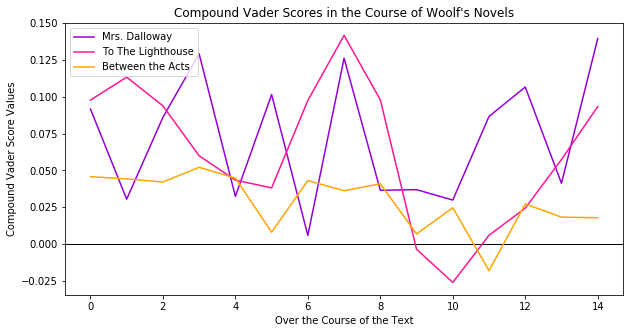

In [38]:
# Vader Compound Chronologically -- Novels
# Line plot with compound vader score across the duration of each novel

# Mrs. Dalloway, 1925
md = mrs_dalloway_vader['vader_compound']
md_ave = md.groupby(np.arange(len(md))//(len(md)/15)).mean()

# To the Lighthouse, 1927
ttl = to_the_lighthouse_vader['vader_compound']
ttl_ave = ttl.groupby(np.arange(len(ttl))//(len(ttl)/15)).mean()

# Between the Acts, 1941
bta = between_the_acts_vader['vader_compound']
bta_ave = bta.groupby(np.arange(len(bta))//(len(bta)/15)).mean()

plt.figure(figsize=(10, 5))
plt.axhline(linewidth=1, color='black')
plt.plot(md_ave, label = "Mrs. Dalloway", color = 'darkviolet')
plt.plot(ttl_ave, label = "To The Lighthouse", color = 'deeppink')
plt.plot(bta_ave, label = "Between the Acts", color = 'orange')

plt.xlabel('Over the Course of the Text')
plt.ylabel('Compound Vader Score Values')
plt.title("Compound Vader Scores in the Course of Woolf's Novels")
plt.legend()
plt.show()

<em> Close Reading the Sentiment Dissonances Between Woolf's Novels:</em>

This visualization highlights a few critical insights within and across Woolf's most notable novels. First, <em>Mrs. Dalloway</em>'s significant number of extremely high and low vader_scores might represent the polarizing and sporadic anxieties of the schizophrenic, shell-shocked WW1 veteran Septimus Smith. Perhaps these spikes signal the extraordinary intensity to which the characters feel depression, mania, trauma, and fervor throughout their narratives. Additionally, towards the end of the novel, Mrs. Dalloway hears of Septimus Smith's suicide, which triggers an onslaught of personal reflection on death and depression -- an episode potentially indicated by the sudden drop in positivity at the end of the novel. 

<em>To the Lighthouse</em> also experiences extreme highs and lows, as shown by the vader_compound score reaching almost as high as 0.15 and subsequently dropping to almost -0.025. <em>To the Lighthouse</em> is divided into three segments; while challenging to discern where these three segments are graphed, we can see three prominent 'highs' at 1, 7, and 15, and two 'lows' at 5 and 10. The gradual increase in the vader score from points 10 to 15 might symbolize the last section of the novel, "The Lighthouse," when the remaining Ramsays and guests return to their summer home after ten years. The increased positivity on the graph could represent the sentimentality shift from the melancholic Part 2, which focused on the abandoned summer home, the implications of WW1, and the Ramsay family's loneliness. In Part 3, we finally see harmony among the characters: Mr. Ramsay praises James on their trip over to the lighthouse, Cam slowly trades her resentment towards her father for compassion, and Lily finally finishes her painting. 

Lastly, this visualization shows <em>Between the Acts</em> as the saddest novel, with vader_compound scores consistently lower than <em>Mrs. Dalloway</em> and <em>To the Lighthouse</em>. The novel's sentiment fluctuates to a much smaller degree than the other two texts, remaining between 0.00 and 0.05. <em>Between the Acts</em> itself flits between not just various characters, but various periods, as Miss La Trobe's play portrays centuries of famous literature and theatre. After multiple pathways and trajectories, the novel ends in a moment of suspension, dispersion, and anticipation. As reflected in the visualization above, rather than sweeping sentiment shifts in <em>Mrs. Dalloway</em> and <em>To the Lighthouse</em>, we see multiple smaller variations in <em>Between the Acts</em>. Towards the end of the novel, we see a plateau -- the curtain's opening, the question left unanswered, the audience's anticlimactic dispersion escaping the literary world and returning to the material one. Woolf, shortly after writing the typescript of <em>Between the Acts</em>, decided to end her own life, due to the onset of another terrible period of mental illness, paired with the anticipation of an oncoming invasion by Hitler. The novel dissipates into an open ending; questions are left unanswered, and the book unfinished; a picture well-suited by the stagnating sentiment.

### Short Stories:
Another primary genre in which Woolf contributed beautiful works of literature was short stories; her two most notable ones being "The Mark on the Wall", her first publication, and "Kew Gardens". We will look at these two short stories, alongside a short story that came a dozen years later: "Street Haunting: A London Adventure", 1930.

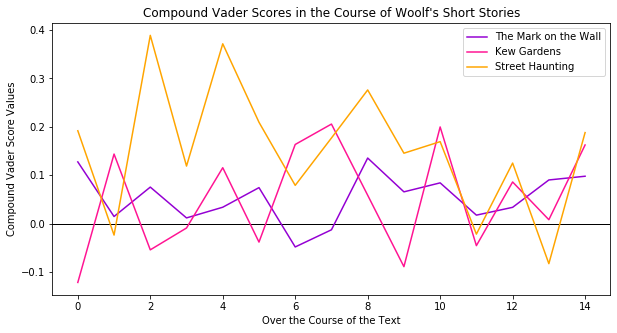

In [39]:
# Vader Compound Chronologically -- Short Stories
# Line plot with compound vader score across the duration of each short story

# Mark On the Wall, 1917
mw = mark_on_the_wall_vader['vader_compound']
mw_ave = mw.groupby(np.arange(len(mw))//(len(mw)/15)).mean()

# Kew Gardens, 1919 
kw = kew_gardens_vader['vader_compound']
kw_ave = kw.groupby(np.arange(len(kw))//(len(kw)/15)).mean()

# Street Haunting, 1930 
sh = street_haunting_vader['vader_compound']
sh_ave = sh.groupby(np.arange(len(sh))//(len(sh)/15)).mean()

plt.figure(figsize=(10, 5))
plt.axhline(linewidth=1, color='black')
plt.plot(mw_ave, label = "The Mark on the Wall", color = 'darkviolet')
plt.plot(kw_ave, label = "Kew Gardens", color = 'deeppink')
plt.plot(sh_ave, label = "Street Haunting", color = 'orange')

plt.xlabel('Over the Course of the Text')
plt.ylabel('Compound Vader Score Values')
plt.title("Compound Vader Scores in the Course of Woolf's Short Stories")
plt.legend()
plt.show()

<em>Critical Analysis of The Emotion Fluctuations in Woolf's Short Stories:</em>

A distinction immediately appears between "The Mark on the Wall" and "Kew Gardens", with "Street Haunting". Perhaps this is a sign of the times: as we saw with her novels, Woolf's work experienced a decline in overall positive sentiment as time went on. The similar sentimentality of "The Mark on the Wall" and "Kew Gardens" might also be explained by how the two literary works are often paired together. "The Mark on the Wall", a subset of the Hogarth Press's first publication, is invaluable how Woolf fills it with incredibly evocative, engaging, and articulate emotions and thoughts stimulated by the observation of a snail. Consequentially, in "Kew Gardens" (1919), Woolf uses the snail from "The Mark on the Wall" as her narrative angle from which the conversations, thoughts, and emotions of passersby are perceived and conveyed. This narrative form was an entirely new way of storytelling, with time and space fragmented, speech and thought fractured. 

Contrarily, "Street Haunting", published in 1927, describes an expedition on London's winter streets at night. Unlike "The Mark on the Wall" and "Kew Gardens," the narrative perspective is transitory; it explores alleyways, dives into bookstores, interacts with passersby, imagines itself in others' homes. However, the two other short stories draft storylines from the perspective of a narrator who stays stationary, either from a narrator sitting in her living room or a snail resting on a flower-bed. Perhaps this influences each short story; the narrators' static nature in the first two texts allows the imaginative insertion of multiple perspectives, hence the oscillating emotion per the various transitions between characters. Meanwhile, in "Street Haunting," the narrator must physically move to 'emotionally' move from perspective to perspective, lending itself to a more tedious, laborious process. As a result, the emotional oscillations tied to switching of visceral perspectives are experienced less frequently but with more intensity.

### Biographies:
Woolf wrote three biographies: <em>Orlando</em>, <em>Flush</em>, and <em>Roger Fry</em>. Due to difficulties accessing an online eBook for <em>Roger Fry</em>, we are able to look at only <em>Orlando</em> and <em>Flush</em>. Below, we perform the same analysis to visualize the changing vader compounds across each biography.

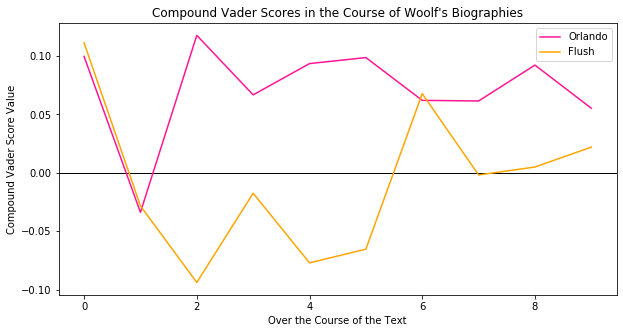

In [40]:
# Vader Compound Chronologically -- Biographies
# Line plot with compound vader score across the duration of each biography

# Orlando, 1928
orl = orlando_vader['vader_compound']
orl_ave = orl.groupby(np.arange(len(orl))//(len(orl)/10)).mean()

# Flush, 1933
flu = flush_vader['vader_compound']
flu_ave = flu.groupby(np.arange(len(flu))//(len(flu)/10)).mean()

plt.figure(figsize=(10, 5))
plt.axhline(linewidth=1, color='black')
plt.plot(orl_ave, label = "Orlando", color = 'deeppink')
plt.plot(flu_ave, label = "Flush", color = 'orange')

plt.xlabel('Over the Course of the Text')
plt.ylabel('Compound Vader Score Value')
plt.title("Compound Vader Scores in the Course of Woolf's Biographies")
plt.legend()
plt.show()

<em> Thinking Critically About the Biographies' Vader Scores in Context</em>:

<em>Flush</em> and <em>Orlando</em> are depicted by their vader_compound scores to be quite the opposite in sentiment throughout each text. According to the graph above, when <em>Orlando</em> is around its peak positivity, <em>Flush</em> is at its peak negativity at that same point in the text. <em>Orlando</em>'s computed positivity makes sense; <em>Orlando</em> fuses biography with fantasy, evading gender and time restrictions. An entertaining escape from Woolf's heavier projects, <em>Orlando</em> serves as a love-letter to Woolf's close friend and lover, Vita Sackville-West. 

Meanwhile, <em>Flush</em> was a comic novel written from the point of view of Elizabeth Barret Browning's cocker spaniel, Flush.  Despite its playful nature, <em>Flush</em> has vader_compound scores that fall into the negative for most of the narrative, which is a surprising result.  Unlike other genre visualizations, the differences across <em>Orlando</em> and <em>Flush</em> are harder to justify. Both biographies are whimsical and light-hearted; however, we see <em>Flush</em> computed to be much sadder than <em>Orlando</em>. It could be useful to look at precisely what sentences are the saddest and happiest in these respective biographies, to see why and how the Vader method found these results. 

In [41]:
# Functions that, for the given text, print the sentence(s) with the lowest and highest vader_compound
def sentence_min(text_vader):
    '''Use the vader scores to locate the sentence associated with the lowest vader_compound score.
    Returns the "saddest" sentence, or the sentence with the lowest vader_compound. '''
    min_ = text_vader[text_vader['vader_compound']==text_vader['vader_compound'].min()]
    print("The most negative, or 'saddest', sentence: \n", min_.iloc[0]['sentence'])
    
def sentence_max(text_vader):    
    '''Use the vader scores to locate the sentence associated with the highest vader_compound score.
    Returns the "happiest" sentence, or the sentence with the highest vader_compound. '''
    max_ = text_vader[text_vader['vader_compound']==text_vader['vader_compound'].max()]
    print("The most positive, or 'happiest' sentence: \n", max_.iloc[0]['sentence'])

We can create a function that allows us to find the lowest vader_compound score for each text and then locate the sentence associated with that score. We can also do this for the highest vader_compound score to see the 'saddest' and the 'happiest' sentences of each text.

In [42]:
# Finding the saddest sentence in Flush
sentence_min(flush_vader)

The most negative, or 'saddest', sentence: 
 Thirst was his worst suffering; but one sip of the thick greenish water that stood in a pail near him disgusted him; he would rather die than drink another.


<em>Thinking Critically About the Biographies' Vader Scores in Context, cont'd</em>:

In <em>Flush</em>, the saddest sentence is grounded in the dog's physical state: his thirst and his disgust for the water in front of him. This could explain why <em>Flush</em> has such a low vader_compound score; rather than being weighed down by more solemn discussions of death, depression, or trauma, the text is littered with negativity regarding more trivial matters. However, as readers, we do not perceive <em>Flush</em> as a necessarily sad text since we discern the negativity about trivial matters from significant ones. 

### Essays
Virginia Woolf was also extremely well-known for her writings promoting liberal politics, particularly the feminist and anti-fascist movements. Her two most notable political pieces are <em>A Room of One's Own</em> and <em>Three Guineas</em>. We can visualize the sentiment across these polemics, alongisde Woolf's two essays, "Mr. Bennett and Mrs. Brown", and "Modern Fiction", that pose compelling literary arguments about modernist novels.

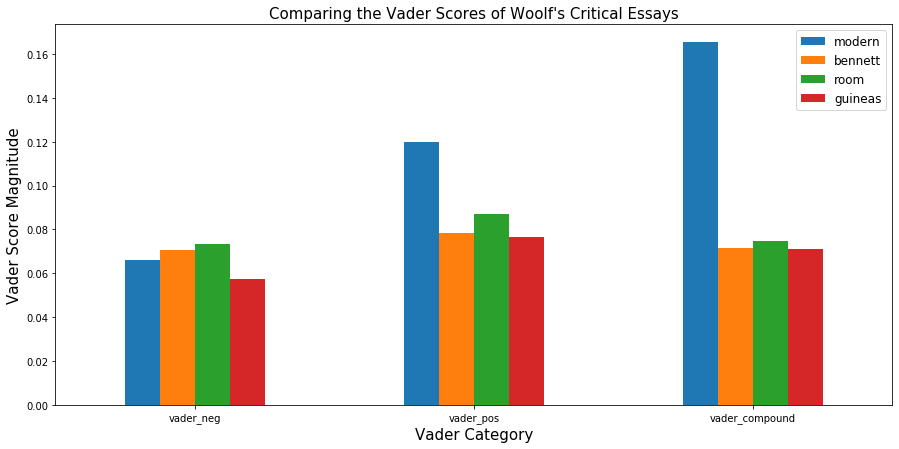

In [43]:
# Bar chart with average negative, positive, and compound vader scores for each polemic/essay
# Ordered chronologically

novel_df = vader_means[['modern', 'bennett', 'room', 'guineas']].drop(['vader_neu'])
ax = novel_df.plot.bar(rot=0, figsize = (15,7))
ax.legend(fontsize=12)

plt.title("Comparing the Vader Scores of Woolf's Critical Essays", fontsize = 15)
plt.xlabel('Vader Category', fontsize = 15)
plt.ylabel('Vader Score Magnitude', fontsize = 15)
plt.show()

<em>Understanding Essay Visualizations Through a Literary Lenses:</em>

This visualization showcases a surprising spike in vader_pos and vader_compound for "Modern Fiction", a spike that fails to be reflected in the similar essay "Mr. Bennett and Mrs. Brown". "Modern Fiction," perhaps the best known of all Virginia Woolf's essays, builds an argument on the materialistic preoccupation of novelists who see only the body and nothing of the mind. She argues that the future novels must leave the external world to instead create subjects out of the interiors of human experiences -- a principle upheld throughout Woolf's novels. In the same vein, Woolf's essay "Mr. Bennett and Mrs. Brown" also discusses literary creation, acting as a literary manifesto repudiating traditional novels that deprived readers of insight into human character. One would expect the two to have very similar sentiment scores. 

Meanwhile, Woolf's essays <em>A Room of One's Own</em> and <em>Three Guineas</em> take a stance on a broader, more controversial stage. <em>A Room of One's Own</em>, published in 1929, stands as the classic essay on feminism, characterized by its shrewd reasoning, foolproof arguments, and engaging evidence. Woolf argues for equal rights for both sexes, proves how women are deprived of powers and privileges, and imagines instances that illustrate how women have been kept mute, maternal, poor, and oppressed. Serving as a sequel to <em>A Room of One's Own</em>, <em>Three Guineas</em>, 1938,  dives into the realm of war and fascism. In the growing threat of another world war, Woolf critiques patriarchy and fascism while highlighting women's oppression in society and the male norms of violence, competition, and domination. Thus, <em>A Room of One's Own</em> and <em>Three Guineas</em> might similar vader scores could have been anticipated. Still, it might be interesting to look at the most negative sentences in these two polemics; do they critique the same societal downfalls and disappointments?

In [44]:
# The least positive sentence in A Room of One's Own
sentence_min(room_of_ones_own_vader)

The most negative, or 'saddest', sentence: 
 His expression suggested that he was labouring under some emotion that made him jab his pen on the paper as if he were killing some noxious insect as he wrote, but even when he had killed it that did not satisfy him; he must go on killing it; and even so, some cause for anger and irritation remained.


In [45]:
# The least positive sentence in Three Guineas
sentence_min(three_guineas_vader)

The most negative, or 'saddest', sentence: 
 ) This raises the difficult question whether those who did not aid in the prosecution of the war, but did what they could to hinder the prosecution of the war, ought to use the vote to which they are entitled chiefly because others 'aided in the prosecution of the war'?


<em>Understanding Essay Visualizations Through a Literary Lenses, cont'd:</em>

There seems to a common thread between these two sentences in the deliberate mention of "killing" and "war" in each respective sentence. In <em>A Room of One's Own</em>, the most negative sentence discusses the male nature of domination or control, how society normalizes violence by men, and engrains in them an insatiable desire to oppress. Then, in <em>Three Guineas</em>, this sentence uses the phrase "prosecution in the war" three times, discussing an individual's role in the war's prosecution. When thinking back to the text, I am sure many other sentences might be more violent. However, it might be the repeated use of that phrase that consistently amplifies the negativity of war; although, in context, one might view the war's prosecution positively.

## 7. In Conclusion...
Emotion, particularly in Woolfean literature, is an incredibly elusive and evasive characteristic to quantify. However, through text-mining, semantic analysis, and data visualizations, we can try to find ways to accurately capture objective illustrations of this very subjective nature that underlays each of Woolf's texts. These dataframes, summary statistics, and visualizations provided new lenses through which we could re-explore and re-imagine Woolf's texts. While our quantitative analyses might not have always given us the answers to our qualitative ambiguities, they provoked intriguing new questions, uncovered unseen similarities across texts, and revealed an uncharted side to understanding the worlds that Woolf created.

## 8. Acknowledgements!
Thank you to Professor Elizabeth Evans for providing me the space and time to take on this challenging expedition! This project would not have been possible without your encouragement, guidance, and everything I have learned from you in ENGL 3520 this past semester.

I would also like to acknowledge Project Gutenberg for publishing free online versions of Virginia Woolf's texts. Without their efforts to digitize, archive, and distribute our society's greatest literary accomplishments, this research project would not have been possible.

Finally, I would like to recognize the informative references used throughout this project, listed below. They were critical in helping me fully understand the Vader method, as well as the Woolfean texts with which I was unfamiliar prior to this project.

### References
Beri, Aditya. “SENTIMENTAL ANALYSIS USING VADER.” Medium, Towards Data Science, 27 May 2020, towardsdatascience.com/sentimental-analysis-using-vader-a3415fef7664. 

Caren, Neal. “Word Lists and Sentiment Analysis.” Neal Caren, 1 May 2019, nealcaren.org/lessons/wordlists/. 

Cersonsky, Emily. “Virginia Woolf.” Virginia Woolf: The Core Curriculum, Columbia Univeristy, 2020, college.columbia.edu/core/content/virginia-woolf. 

McGinn, Emily, et al. “Scholarly Editing.” Scholarly Editing: The Annual of the Association for Documentary Editing, 2014, scholarlyediting.org/2014/editions/intro.markonthewall.html. 

Virginia Woolf, The Virginia Woolf Reader. Ed. Mitchell Leaska. Harcourt, 1984.